# Bank Marketing Dataset Introduction

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. The classification goal is to predict if the client will subscribe a term deposit program which is defined by "yes" or "no" in the variable y. 

Attribute information can be specified as in:

<b>Input variables:</b>
<ol>
    <li>age (numeric)</li>
    <li>job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')</li>
    <li>marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)</li>
    <li>education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')</li>
    <li>default: has credit in default? (categorical: 'no','yes','unknown')</li>
    <li>balance (numeric)</li>
    <li>housing: has housing loan? (categorical: 'no','yes','unknown')</li>
    <li>loan: has personal loan? (categorical: 'no','yes','unknown')</li>
    <li>contact: contact communication type (categorical: 'cellular','telephone')</li>
    <li>day</li>
    <li>month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')</li>
    <li>duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.</li>
    <li>campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    <li>pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)</li>
    <li>previous: number of contacts performed before this campaign and for this client (numeric)</li>
    <li>poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')</li>
</ol>

<b>Output variable (desired target):</b>
<ol>
    <li>y - has the client subscribed a term deposit? (binary: 'yes','no')</li>
</ol>

In [16]:
import time
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import torch
from torch import nn, optim
from torch.utils import data
from torch.utils.data import DataLoader

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 1. Import Dataset

In [3]:
df = pd.read_csv('dataset/bank-full.csv', sep=";")
df = df.drop(columns=['duration'])

print(df.shape)
print(df.y.value_counts())
df.head()

(45211, 16)
no     39922
yes     5289
Name: y, dtype: int64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  campaign   45211 non-null  int64 
 12  pdays      45211 non-null  int64 
 13  previous   45211 non-null  int64 
 14  poutcome   45211 non-null  object
 15  y          45211 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.5+ MB


# 2. Preprocessing

In [5]:
cat_df = pd.DataFrame()
le = LabelEncoder()
for i in df.columns:
    if df[i].dtype == 'object':
        print(i, df[i].nunique())
        cat_df[i] = le.fit_transform(df[i])
        
num_df = pd.DataFrame()
for i in df.columns:
    if df[i].dtype == 'int64':
        num_df[i] = df[i]
        
df_concat = pd.concat([cat_df, num_df], axis=1)
df_concat.head()

job 12
marital 3
education 4
default 2
housing 2
loan 2
contact 3
month 12
poutcome 4
y 2


,job,marital,education,default,housing,loan,contact,month,poutcome,y,age,balance,day,campaign,pdays,previous
0,4,1,2,0,1,0,2,8,3,0,58,2143,5,1,-1,0
1,9,2,1,0,1,0,2,8,3,0,44,29,5,1,-1,0
2,2,1,1,0,1,1,2,8,3,0,33,2,5,1,-1,0
3,1,1,3,0,1,0,2,8,3,0,47,1506,5,1,-1,0
4,11,2,3,0,0,0,2,8,3,0,33,1,5,1,-1,0


In [6]:
X = df_concat.drop('y', axis=1)
y = df_concat['y']

undersample = imblearn.under_sampling.NearMiss(version=1, n_neighbors=3)
X, y = undersample.fit_resample(X, y)

y.value_counts()

1    5289
0    5289
Name: y, dtype: int64

# 3. Visualisation

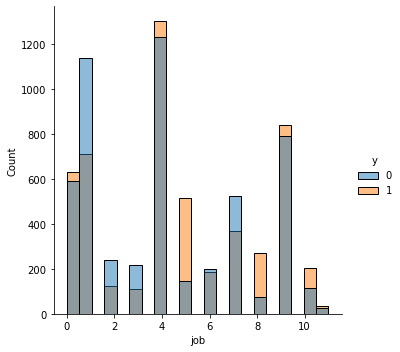

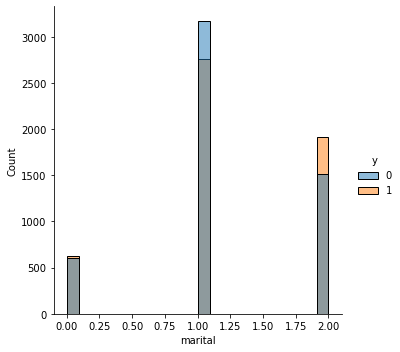

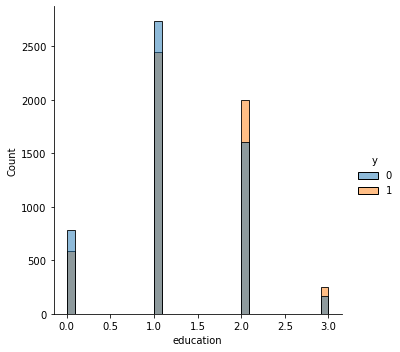

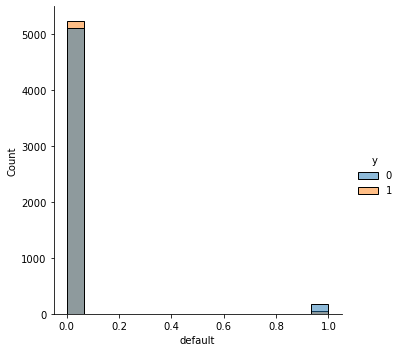

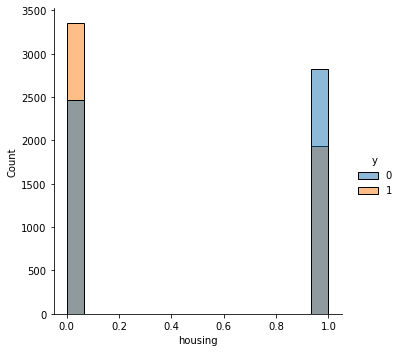

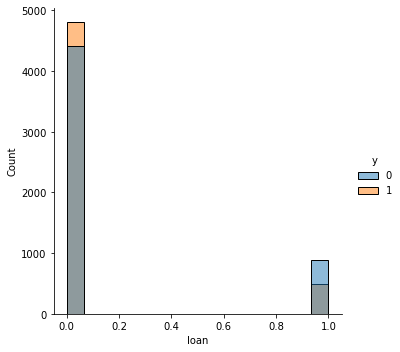

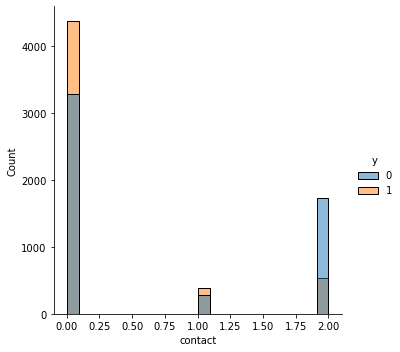

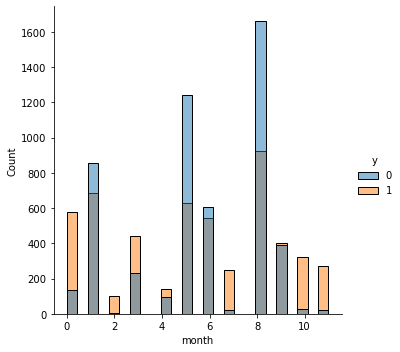

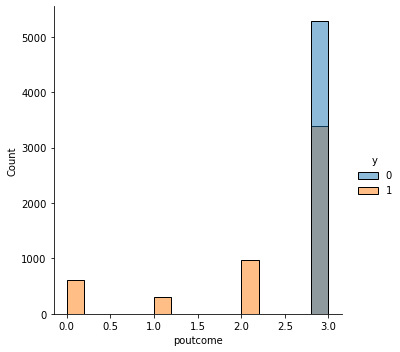

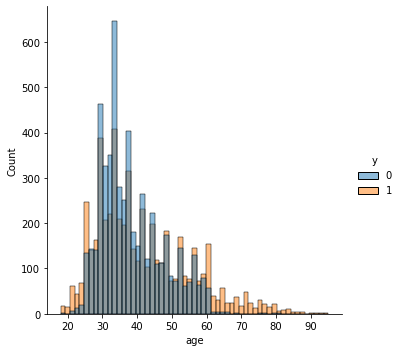

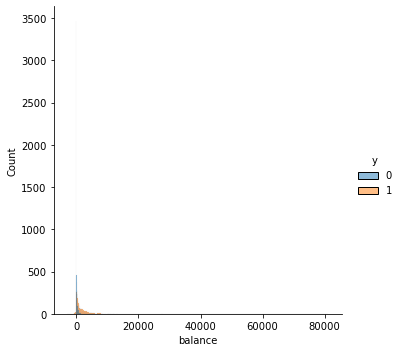

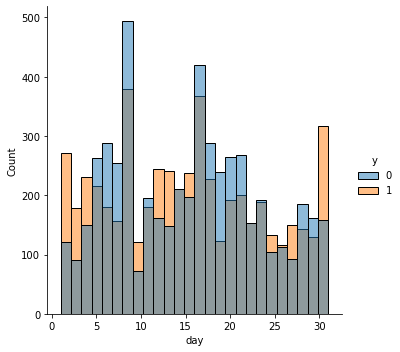

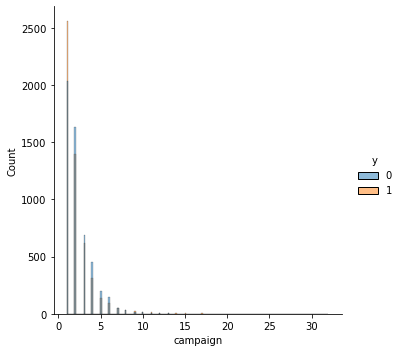

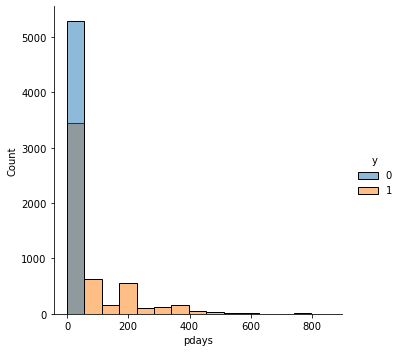

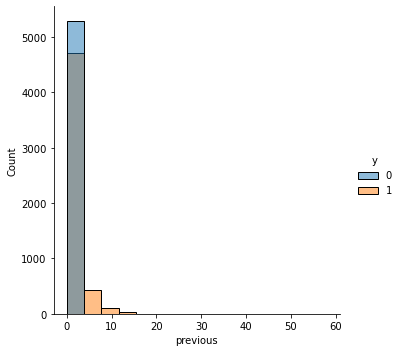

In [7]:
for i in X.columns:
#     if i in cat_df or i == 'day':
    sns.displot(X, x=i, hue=y, fill=True)
#     else:
#         sns.displot(X, x=i, hue=y, kind="kde", fill=True)

# 4. Modelling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=21)

# convert splitted dataset to numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

- learning rate = 0.1
- nodes in:
  - input layer = 56
  - hidden layer 1 = 100
  - hidden layer 2 = 100
  - hidden layer 3 = 100
  - output layer = 1
- activation function
  - hidden layer = sigmoid
  - output layer = sigmoid

In [17]:
model = nn.Sequential(
    nn.Linear(len(X.columns), 100), nn.Sigmoid(), 
    nn.Linear(100,100), nn.Sigmoid(),
    nn.Linear(100,100), nn.Sigmoid(),
    nn.Linear(100, 100), nn.Sigmoid(),  
    nn.Linear(100, 1), nn.Sigmoid()
)

optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.BCELoss()

train_set = data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train).int())
test_set = data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test).int())

trainloader = DataLoader(train_set, batch_size=64)
testloader = DataLoader(test_set, batch_size=64)

cost_list = []
acc_list = []

start_time = time.time()
for epoch in range(2000):
    running_loss = 0.0
    running_corrects = 0.0
    for inp, label in trainloader:
        inp, label = inp.float(), label.float()
        output = model(inp)
        val = (output.data > 0.5).float()
        val = val.view(1, -1)

        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()

        # adjust the weight
        optimizer.step()

        running_loss += loss.item()*inp.size(0)
        running_corrects += torch.sum((val==label))
    
    epoch_loss = running_loss/len(trainloader.dataset)
    epoch_acc = running_corrects.double()/len(trainloader.dataset)

    cost_list.append(epoch_loss)
    acc_list.append(epoch_acc)

    if epoch%100==0:
        print(f'Epoch - {epoch} Loss..{epoch_loss}...Accuracy {epoch_acc}')

end_time = time.time()
print("%s seconds" % round(end_time - start_time,2))

C:\Users\ibrahi15\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\ibrahi15\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch - 0 Loss..0.6966159654351111...Accuracy 0.49858189553297094
Epoch - 100 Loss..0.3744430936092858...Accuracy 0.8299456393287639
Epoch - 200 Loss..0.3589161950711859...Accuracy 0.8496809264949184
Epoch - 300 Loss..0.42754638945907036...Accuracy 0.8104467029071142
Epoch - 400 Loss..0.42762733557437843...Accuracy 0.8110375797683763
Epoch - 500 Loss..0.42719471855412644...Accuracy 0.8105648782793666
Epoch - 600 Loss..0.41759835012103896...Accuracy 0.8178917513590168
Epoch - 700 Loss..0.3281837465055331...Accuracy 0.8462538406995982
Epoch - 800 Loss..0.3356190129984245...Accuracy 0.82829118411723
Epoch - 900 Loss..0.33356870526654364...Accuracy 0.8574805010635783
Epoch - 1000 Loss..0.3325171339345638...Accuracy 0.8490900496336563
Epoch - 1100 Loss..0.318146130141849...Accuracy 0.8555896951075396
Epoch - 1200 Loss..0.3166403822993533...Accuracy 0.849562751122666
Epoch - 1300 Loss..0.3098305330169987...Accuracy 0.8646891987709762
Epoch - 1400 Loss..0.30035647189214254...Accuracy 0.866580

In [32]:
predictions = []
for inp, _ in testloader:
    output = model(inp.float())
    preds = (output.data > 0.5).float()
    predictions.append(preds.view(1,-1).numpy().ravel())

predictions = np.concatenate(np.array(predictions)).ravel()

print('accuracy: ',accuracy_score(y_test, predictions))
print('classification report \n', classification_report(y_test, predictions))

accuracy:  0.8189981096408318
classification report 
               precision    recall  f1-score   support

           0       0.88      0.74      0.80      1058
           1       0.77      0.90      0.83      1058

    accuracy                           0.82      2116
   macro avg       0.83      0.82      0.82      2116
weighted avg       0.83      0.82      0.82      2116



<ipython-input-32-c6da46839b3b>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  predictions = np.concatenate(np.array(predictions)).ravel()


[[778 280]
 [103 955]]


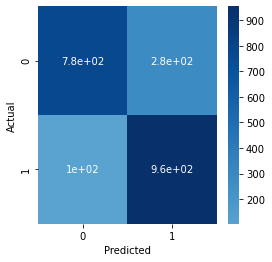

In [34]:
def confusion_matrix_heatmap(cm, index, dim):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (dim, dim)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="Blues", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

print(confusion_matrix(y_test, predictions))
confusion_matrix_heatmap(confusion_matrix(y_test, predictions), y.unique(), 4)